In [1]:
import urllib.request, urllib.error, urllib.parse
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast
from time import sleep
import time

Now, individual article content needs scraping. The below listing uses `BeautifulSoup` and the `requests` library to scrape the contents of a given url, which was sourced from the sitemap. The `lxml` parser was chosen again for its speed, and since the necessary external C dependency had already been installed with the `lxml-xml` parser during the XML sitemap scraping, no additional setup was needed. 

Richardson, L. (2004–2025). Beautiful Soup Documentation. Retrieved April 27, 2025, from https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser 

In [2]:

def extract_html_from_url(url):
    """given a url, return a soup object which contains the html content of the page"""
    request = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html_content = urllib.request.urlopen(request).read().decode('utf-8')
    soup = BeautifulSoup(html_content, 'lxml')
    return soup


The contents of the HTML were analysed and parsed into a dictionary capturing the title, author, date, sector, stock codes, and the article body, as demonstrated in the below listing, utilising Beautiful Soup to extract data from the relevant tags. Below is an example output from the parsing process:
```{python}
soup_test = extract_html_from_url('https://smallcaps.com.au/galan-lithium-directors-show-confidence-share-purchase/')
parsed_dict = parse_html_to_dict(soup_test)
parsed_dict

{'title': 'Galan Lithium directors show confidence with $1.4 million share purchase',
 'author': 'Colin Hay',
 'date_string': 'May 23, 2024',
 'sector': 'Mining',
 'stock_codes': ['ASX:GLN'],
 'document': 'Galan Lithium (ASX: GLN) managing director Juan Pablo....}
```

In [3]:
def parse_html_to_dict(soup_obj):    
    """
    Parse the HTML content of a Small Caps article into a dictionary, extracting the title, author, date, sector, stock codes, and document.
    """

    # Parse the title from the <h1> element; fall back to <title> if not found.
    title_tag = soup_obj.find("h1", class_="c-post-header__title")
    if title_tag:
        title = title_tag.get_text(strip=True)
    else:
        title = soup_obj.title.get_text(strip=True) if soup_obj.title else None

    # parse the author from the header
    author_tag = soup_obj.find('a', class_='c-post-header__author-link')
    author = author_tag.get_text(strip=True) if author_tag else None

    # parse the date from the first <time> tag
    date_tag = soup_obj.find('time')
    date_string = date_tag.get_text(strip=True) if date_tag else None

    # parse the sector from the navigation
    sector = None
    nav_section = soup_obj.find("div", class_="c-post__navigation")
    if nav_section:
        sector_tag = nav_section.find("a", class_="c-post__navigation-link")
        sector = sector_tag.get_text(strip=True) if sector_tag else None

    # parse the stock codes
    stock_codes = []
    # look for any div whose class attribute contains "c-tags"
    tags_container = soup_obj.find(
        lambda tag: tag.name == "div" and tag.get("class") and any("c-tags" in c for c in tag.get("class"))
    )
    if tags_container:
        stock_text_span = tags_container.find("span", class_="c-tags__text")
        if stock_text_span and "Stock Codes" in stock_text_span.get_text():
            # Try to find an inner container if available
            inner = tags_container.find("div", class_="c-tags__inner")
            if inner:
                stock_codes = [a.get_text(strip=True) for a in inner.find_all("a", class_="c-tags__item c-tags__item--link")]
            else:
                stock_codes = [a.get_text(strip=True) for a in tags_container.find_all("a", class_="c-tags__item c-tags__item--link")]

    # parse the article body
    body_tag = soup_obj.find("div", class_="c-rich-text c-post__rich-text")
    if body_tag:
        # Use "\n" as separator to preserve paragraph breaks
        document = body_tag.get_text(separator = " ", strip=True)
    else:
        document = None

    return {
        'title': title,
        'author': author,
        'date_string': date_string,
        'sector': sector,
        'stock_codes': stock_codes,
        'document': document
    }

## Define existing Data and Scrape
Defining the existing data allows for scraping in installments, rather than in one go

In [4]:

# Initialize an empty DataFrame to store the articles
crawl_throttle_time_s = 3 

# Read the metadata CSV file
article_metadata = pd.read_csv('../data/article_metadata.csv')
# Read the scraped data CSV file and convert the 'stock_codes' column from string to list
article_df = pd.read_csv('../data/article_scraped_data.csv', converters={'stock_codes': ast.literal_eval})

In [ ]:
unscraped_articles = article_metadata.loc[article_metadata['url'].isin(article_df['url']) == False]
number_of_articles = 500
crawl_throttle_time_s = 3

for index, row in unscraped_articles.iloc[0:number_of_articles-1].iterrows(): # iterate through websites urls in article_metadata
    print(f"Article {index+1}/{number_of_articles}...")
    url = row['url']

    start_time = time.time()
    try:
        soup = extract_html_from_url(url)
        parsed = parse_html_to_dict(soup)
        parsed['url'] = url
        article_df = pd.concat([article_df, pd.DataFrame([parsed])], ignore_index=True)
        article_df.to_csv('../data/article_scraped_data.csv', index=False)
    except Exception as e: 
        print(f"Error processing {url} at index {index}: {e}")
    
    elapsed_time = time.time() - start_time
    if elapsed_time < crawl_throttle_time_s:
        sleep(crawl_throttle_time_s - elapsed_time)


Article 1509/200...
Article 1510/200...
Article 1511/200...
Article 1512/200...
Article 1513/200...
Article 1514/200...
Article 1515/200...
Article 1516/200...
Article 1517/200...
Article 1518/200...
Article 1519/200...
Article 1520/200...
Article 1521/200...
Article 1522/200...
Article 1523/200...
Article 1524/200...
Article 1525/200...
Article 1526/200...
Article 1527/200...
Article 1528/200...
Article 1529/200...
Article 1530/200...
Article 1531/200...
Article 1532/200...
Article 1533/200...
Article 1534/200...
Article 1535/200...
Article 1536/200...
Article 1537/200...
Article 1538/200...
Article 1539/200...
Article 1540/200...
Article 1541/200...
Article 1542/200...
Article 1543/200...
Article 1544/200...
Article 1545/200...
Article 1546/200...
Article 1547/200...
Article 1548/200...
Article 1549/200...
Article 1550/200...
Article 1551/200...
Article 1552/200...
Article 1553/200...
Article 1554/200...
Article 1555/200...
Article 1556/200...
Article 1557/200...
Article 1558/200...


augment the articles_df with information from `../data/ASXListedCompanies.csv` which was sourced from (Australian Securities Exchange, n.d.)

Australian Securities Exchange. (n.d.). Company directory. ASX. https://www.asx.com.au/markets/trade-our-cash-market/directory 

# Augment and Clean Data
Augment the data with australian stock exchange data. More "granular" that the broad sweeping categories that are provided by the smallcaps website.

In [7]:
asx_companies_df = pd.read_csv('../data/ASXListedCompanies.csv')
asx_companies_df['code'] = "ASX:" + asx_companies_df['ASX code']
asx_companies_df

# article_df['stock_codes'] is a cell containing a list of stock code
# create a new column 'stock_code_instustries' which is a list of industries for each stock code found in the asx_comnpaies_df['GICS industry group']
def get_industries(stock_codes):
    if not stock_codes:  # Check if the list is empty
        return None
    industries = asx_companies_df.loc[asx_companies_df['code'].isin(stock_codes), 'GICS industry group']
    return set(industries) if not industries.empty else None

# Create a column for stock code industries (list of industries)
article_df['stock_code_industries'] = article_df['stock_codes'].apply(get_industries)

# Create a column for stock code industry (single industry)
def get_most_popular_industry(industries):
    if industries is None or not industries:  # Handle None or empty set
        return None
    industry_counts = pd.Series(list(industries)).value_counts()
    return industry_counts.idxmax()

article_df['stock_code_industry'] = article_df['stock_code_industries'].apply(get_most_popular_industry)
article_df

# print out a list of all unique stock code industries
unique_industries = set()
for industries in article_df['stock_code_industries']:
    if industries:  # Check if industries is not None
        unique_industries.update(industries)
unique_industries

industry_long_name_to_industry_short_name = {
    "Automobiles & Components": "Auto & Parts",
    "Banks": "Banks",
    "Capital Goods": "Capital Goods",
    "Class Pend": "Classification Pending",
    "Commercial & Professional Services": "Commercial Services",
    "Consumer Discretionary Distribution & Retail": "Retail",
    "Consumer Durables & Apparel": "Durables & Apparel",
    "Consumer Services": "Consumer Services",
    "Energy": "Energy",
    "Equity Real Estate Investment Trusts (REITs)": "Real Estate Invstmt.",
    "Financial Services": "Financial Services",
    "Food, Beverage & Tobacco": "F&B & Tobacco",
    "Health Care Equipment & Services": "Medical Equipment & Services",
    "Household & Personal Products": "Household & Personal Goods",
    "Materials": "Materials",
    "Media & Entertainment": "Media & Entertainment",
    "Not Applic": "Not Applicable",
    "Pharmaceuticals, Biotechnology & Life Sciences": "Pharma & Biotech",
    "Real Estate Management & Development": "Real Estate Mgt & Dev",
    "Semiconductors & Semiconductor Equipment": "Semiconductors",
    "Software & Services": "Software & Services",
    "Technology Hardware & Equipment": "Tech Hardware",
    "Telecommunication Services": "Telecom Services",
    "Transportation": "Transportation",
    "Utilities": "Utilities",
}

#map the long name to the short name in the dataframe
article_df['stock_code_industry'] = article_df['stock_code_industry'].map(industry_long_name_to_industry_short_name)
df = article_df
df = df.dropna(subset=['document']).reset_index(drop=True)
df = df.loc[df['sector'] != 'Hot Topics']
df

,title,author,date_string,sector,stock_codes,document,url,stock_code_industries,stock_code_industry
3,GreenHy2 secures H2Core deal to advance superc...,Colin Hay,"March 21, 2025",Energy,[ASX:H2G],Solid state hydrogen storage developer GreenHy...,https://smallcaps.com.au/greenhy2-h2core-deal-...,{Commercial & Professional Services},Commercial Services
4,Compumedics reaches $20m in Chinese MEG sales ...,Colin Hay,"March 21, 2025",Biotech,[ASX:CMP],Brain research technologies specialist Compume...,https://smallcaps.com.au/compumedics-chinese-m...,{Health Care Equipment & Services},Medical Equipment & Services
5,CZR Resources receives $75m offer for Robe Mes...,Colin Hay,"March 21, 2025",Mining,[ASX:CZR],CZR Resources (ASX: CZR) has received a condit...,https://smallcaps.com.au/czr-resources-offer-r...,{Materials},Materials
7,Arafura signs five-year offtake deal with Trax...,Colin Hay,"March 20, 2025",Mining,[ASX:ARU],Arafura Rare Earths (ASX: ARU) has signed a bi...,https://smallcaps.com.au/arafura-five-year-off...,{Materials},Materials
8,International Graphite confirms strong economi...,Colin Hay,"March 20, 2025",Mining,[ASX:IG6],International Graphite (ASX: IG6) has received...,https://smallcaps.com.au/international-graphit...,{Capital Goods},Capital Goods
...,...,...,...,...,...,...,...,...,...
1693,Adriatic Metals produces first concentrate at ...,Colin Hay,"February 29, 2024",Mining,[ASX:ADT],Adriatic Metals (ASX: ADT) has overcome a deli...,https://smallcaps.com.au/adriatic-metals-produ...,{Materials},Materials
1694,Nova Minerals targets NASDAQ dual listing to i...,Colin Hay,"February 29, 2024",Mining,[ASX:NVA],Nova Minerals (ASX: NVA) has confirmed its pro...,https://smallcaps.com.au/nova-minerals-targets...,{Materials},Materials
1695,Radiopharm Theranostics doses first patient in...,Imelda Cotton,"February 29, 2024",Biotech,[ASX:RAD],Biotechnology company Radiopharm Theranostics ...,https://smallcaps.com.au/radiopharm-theranosti...,"{Pharmaceuticals, Biotechnology & Life Sciences}",Pharma & Biotech
1696,Boss Energy on track to produce first drum of ...,Imelda Cotton,"February 29, 2024",Mining,[ASX:BOE],Boss Energy (ASX: BOE) has started commissioni...,https://smallcaps.com.au/boss-energy-on-track-...,{Energy},Energy


C:\Users\hkrug\AppData\Local\Temp\ipykernel_28192\1037393861.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(sector_counts.index, rotation=45, ha='right')
C:\Users\hkrug\AppData\Local\Temp\ipykernel_28192\1037393861.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(industry_counts.index, rotation=45, ha='right')


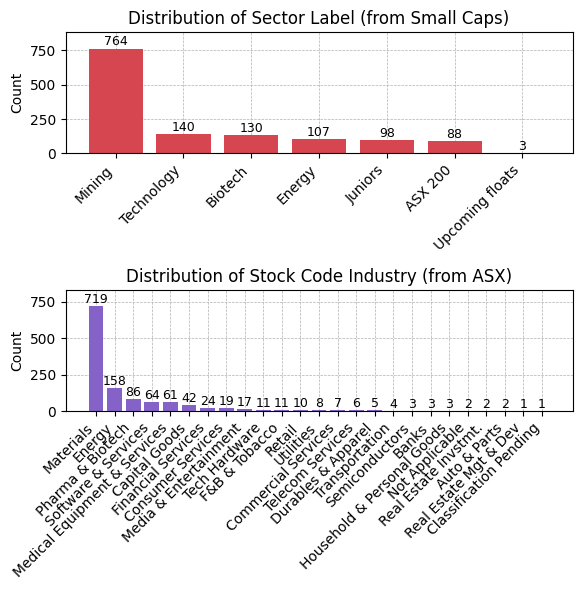

In [8]:
# Plot the value counts of the sector column on one subplot and the value counts of the stock_code_industry column on another subplot

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Plot sector value counts
sector_counts = df['sector'].value_counts(ascending=False)
axes[0].bar(sector_counts.index, sector_counts.values, color='#D64650', zorder=2)
axes[0].set_title('Distribution of Sector Label (from Small Caps)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
axes[0].set_xticklabels(sector_counts.index, rotation=45, ha='right')
axes[0].set_ylim(0, axes[0].get_ylim()[1] * 1.1)

# Add value labels to the bars
for i, count in enumerate(sector_counts.values):
    axes[0].text(i, count + 0.5, f'{int(count)}', ha='center', va='bottom', fontsize=9)

# Plot stock_code_industry value counts
industry_counts = df['stock_code_industry'].value_counts(ascending=False)
axes[1].bar(industry_counts.index, industry_counts.values, color='#8562C8', zorder=2)
axes[1].set_title('Distribution of Stock Code Industry (from ASX)')
axes[1].set_ylabel('Count')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
axes[1].set_xticklabels(industry_counts.index, rotation=45, ha='right')
axes[1].set_ylim(0, axes[1].get_ylim()[1] * 1.1)

# Add value labels to the bars
for i, count in enumerate(industry_counts.values):
    axes[1].text(i, count + 0.5, f'{int(count)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Article EDA

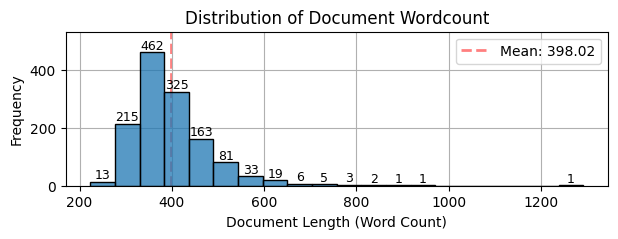

In [9]:
# Calculate document lengths
df['document_length'] = df['document'].apply(lambda x: len(x.split()))
# Plot histogram with KDE
plt.figure(figsize=(7, 2))
sns.histplot(df['document_length'], bins=20, stat="count", zorder=2)

# Add labels to each bar
for patch in plt.gca().patches:
    height = patch.get_height()
    if height > 0:  # Only label bars with a height greater than 0
        plt.text(patch.get_x() + patch.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Add vertical mean line
mean_length = df['document_length'].mean()
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}', zorder=0, alpha=0.5)
# multiply the y scale by 1.1 to make room for the mean line label
plt.ylim(0, plt.gca().get_ylim()[1] * 1.1)
# Customize plot
plt.title('Distribution of Document Wordcount')
plt.xlabel('Document Length (Word Count)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, zorder=0)
plt.show()


C:\Users\hkrug\AppData\Local\Temp\ipykernel_28192\3763524142.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=stock_code_counts.index, y=stock_code_counts.values, palette=[sector_color_map[sector] for sector in stock_code_sectors], zorder=2)


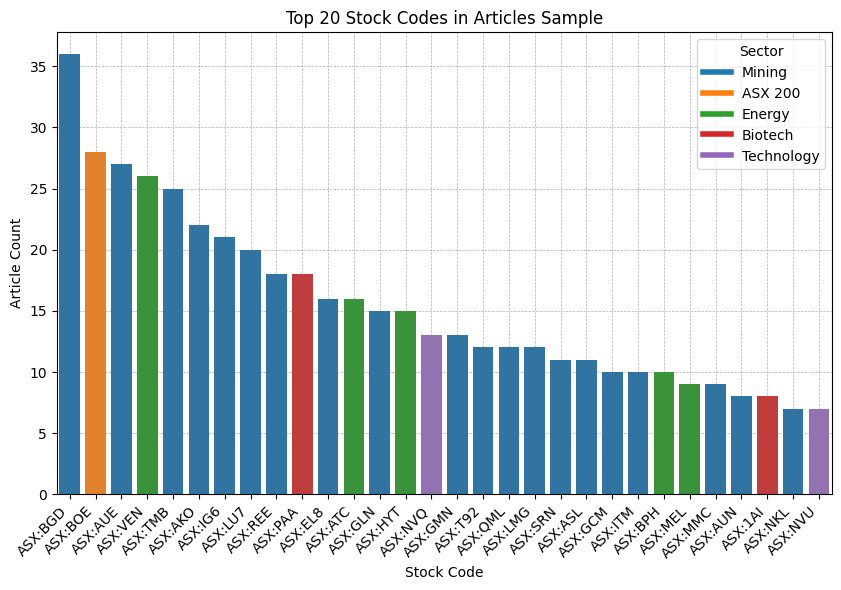

In [12]:
# Flatten the list of stock codes
stock_codes = df['stock_codes'].explode()
# Count the occurrences of each stock code
stock_code_counts = stock_codes.value_counts().head(30)

# Create a mapping of stock codes to sectors
stock_to_sector = df[['stock_codes', 'sector']].dropna().explode('stock_codes').drop_duplicates(subset=['stock_codes']).set_index('stock_codes')['sector']

# Map the stock codes to their respective sectors
stock_code_sectors = stock_code_counts.index.map(stock_to_sector)

# Create a color palette for the sectors
unique_sectors = stock_code_sectors.unique()
colors = sns.color_palette('tab10', len(unique_sectors))
sector_color_map = dict(zip(unique_sectors, colors))

# Plot the distribution
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=stock_code_counts.index, y=stock_code_counts.values, palette=[sector_color_map[sector] for sector in stock_code_sectors], zorder=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
plt.title('Top 20 Stock Codes in Articles Sample')
plt.xlabel('Stock Code')
plt.ylabel('Article Count')
plt.xticks(rotation=45, ha='right')

# Create a legend
handles = [plt.Line2D([0], [0], color=sector_color_map[sector], lw=4) for sector in unique_sectors]
plt.legend(handles, unique_sectors, title='Sector', loc='best')

plt.show()


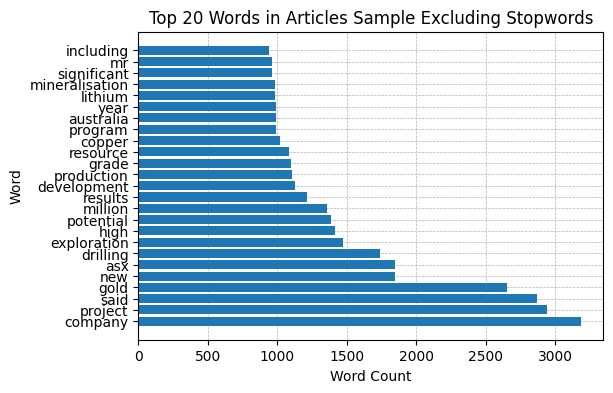

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# tokenize the document excluding stopwords
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['document'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
word_counts_df = pd.DataFrame({'word': words, 'count': word_counts})
top_words_df = word_counts_df.nlargest(25, 'count')

# plot the top 20 words
plt.figure(figsize=(6, 4))
plt.barh(top_words_df['word'], top_words_df['count'], zorder=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
plt.title('Top 20 Words in Articles Sample Excluding Stopwords')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

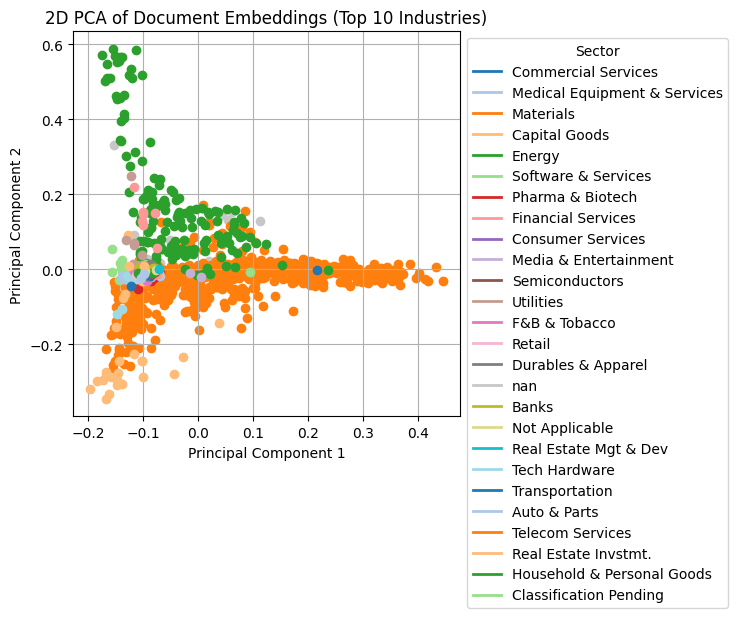

In [17]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tokenized_documents = vectorizer.fit_transform(df['document'])

industry_counts = df['stock_code_industry'].value_counts()
industry_zorder_map = {industry: rank + 1 for rank, industry in enumerate(industry_counts.index)}

industries = df['stock_code_industry'].unique()
colors = sns.color_palette('tab20', len(industries))
principle_components = PCA(n_components=2).fit_transform(tokenized_documents.toarray())  # Fit the PCA to the TF-IDF matrix

pca_df = pd.DataFrame(principle_components, columns=['PC1', 'PC2'])
filtered_sector_color_map = dict(zip(industries, colors))
# Plot the biplot with adjusted zorder
plt.figure(figsize=(5, 5))

for i in range(len(pca_df)):
    sector = df['stock_code_industry'].iloc[i]
    color = filtered_sector_color_map.get(sector, 'black')
    zorder = industry_zorder_map.get(sector, 0)  # Default zorder is 0 if sector is not found
    plt.scatter(pca_df['PC1'][i], pca_df['PC2'][i], color=color, alpha=1, zorder=zorder)

handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
labels = industries
plt.legend(handles, labels, title='Sector', loc='upper left', bbox_to_anchor=(1, 1))
plt.title('2D PCA of Document Embeddings (Top 10 Industries)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
